In [1]:
import json
import requests
import numpy as np
import pandas as pd

from tools import visualize
from llmtime import Scaler, Serializer

In [2]:
def create_chat_completion(model, messages, base_url = ""):
    data = {
        "model": model,
        "messages": messages,
        # "max_tokens": 2048,
        # "temperature": 0.5,
        # "top_p": 0.2,
    }
    
    response = requests.post(f"{base_url}/v1/chat/completions", json=data, stream=False)
    if response.status_code == 200:
        decoded_line = response.json()
        content = decoded_line.get("choices", [{}])[0].get("message", "").get("content", "")
        return content
    else:
        print("Error:", response.status_code)
        return None

In [3]:
num_samples = 10
model = "chatglm3-6b"
sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas.\n"
extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:\n"
continue_input = "Continue."

In [4]:
data = pd.read_csv("./data/air_passengers.csv")["value"].values
train_data = data[:96]
test_data = data[96:]
pred_len = len(test_data)

print(train_data.shape, test_data.shape)

scaler = Scaler(train_data)
transformed_train_data = scaler.transform(train_data)

(96,) (48,)


298, 315, 357, 348, 324, 366, 404, 404, 369, 318, 274, 315, 307, 339, 384, 366, 336, 407, 469, 469, 434, 360, 304, 381, 395, 410, 493, 449, 475, 493, 555, 555, 511, 446, 398, 458, 472, 499, 538, 502, 508, 612, 647, 683, 585, 532, 475, 541, 546, 546, 665, 662, 644, 686, 748, 771, 668, 591, 499, 561, 570, 523, 662, 638, 659, 748, 860, 834, 733, 644, 567, 644, 683, 656, 757, 763, 766, 899, 1044, 994, 890, 777, 668, 789, 807, 786, 905, 893, 908, 1074, 1189, 1165, 1017, 872, 769, 872, 
1
2
3
4
5
6
7
8
9
10
(10, 48)


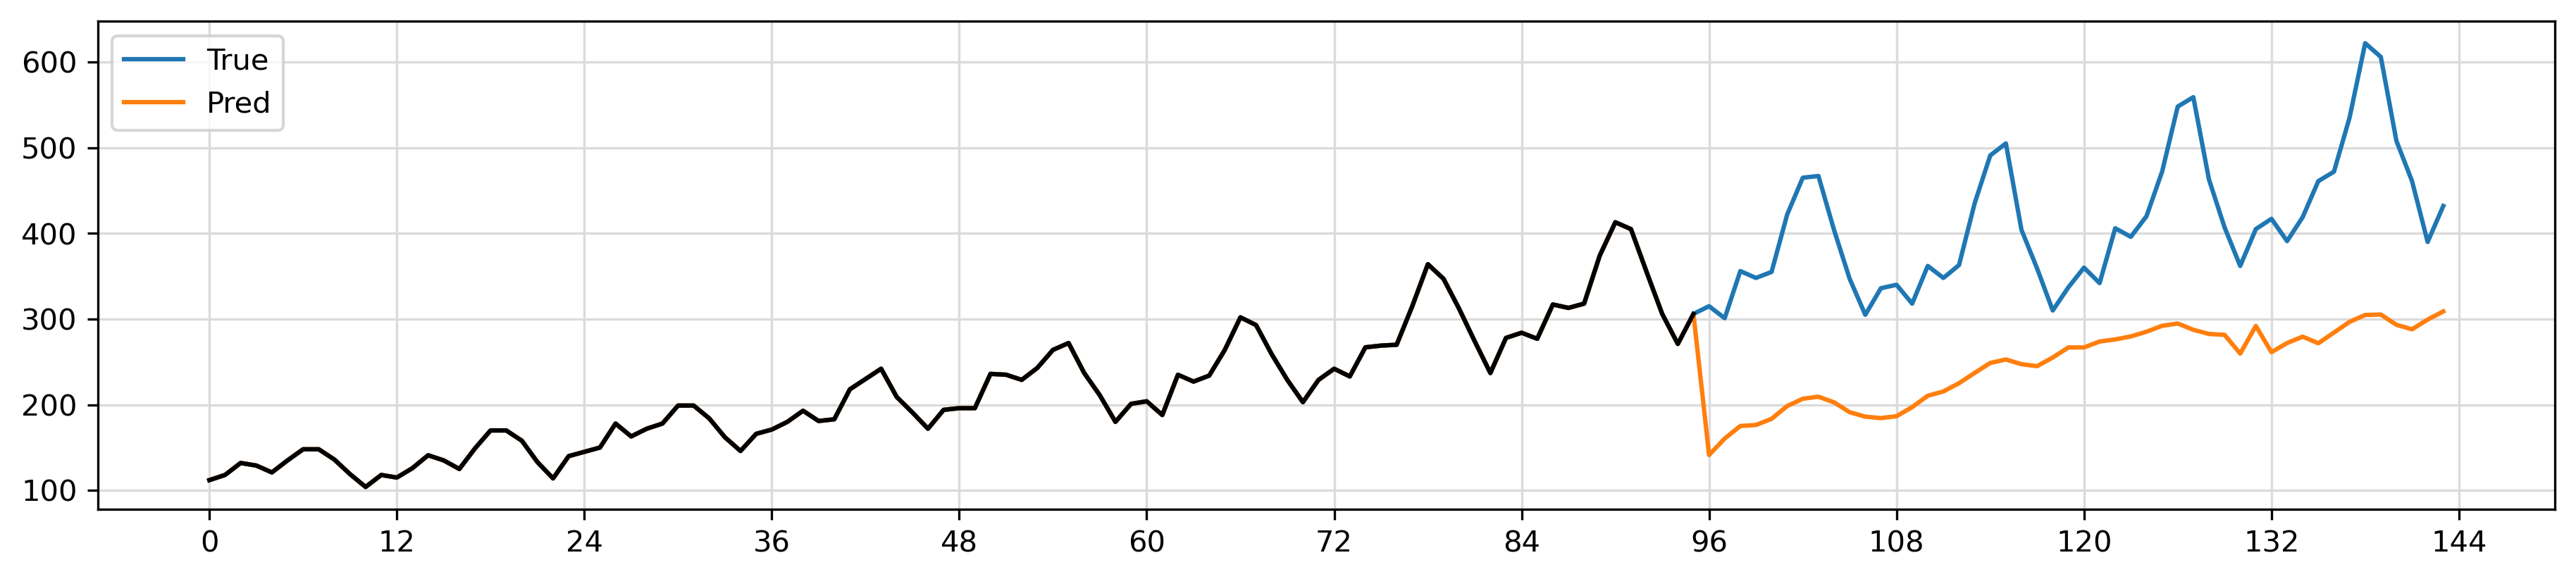

In [5]:
serializer = Serializer(time_sep=', ', bit_sep='', minus_sign='-',)
serialized_train_data = serializer.serialize(transformed_train_data)
print(serialized_train_data)

pred_list = []
i = 0
while i < num_samples:    
    try:
        question = [
            {"role": "system", "content": sys_message},
            {"role": "user", "content": extra_input + serialized_train_data}
        ]

        preds = []
        while len(preds) < pred_len:
            serialized_answer = create_chat_completion("chatglm3-6b", question)
            transformed_answer = serializer.deserialize(serialized_answer)[:-1]
            answer = scaler.inv_transform(transformed_answer)
            preds.extend(answer)

            question.append({"role": "assistant", "content": serializer.serialize(transformed_answer)})
            question.append({"role": "user", "content": continue_input})

        pred_list.append(preds[:pred_len])
        i += 1
        print(i)
    except:
        pass

pred_list = np.array(pred_list)
print(pred_list.shape)
pred_data = np.mean(pred_list, axis=0)
visualize(train_data, test_data, pred_data)

 2 9 8 , 3 1 5 , 3 5 7 , 3 4 8 , 3 2 4 , 3 6 6 , 4 0 4 , 4 0 4 , 3 6 9 , 3 1 8 , 2 7 4 , 3 1 5 , 3 0 7 , 3 3 9 , 3 8 4 , 3 6 6 , 3 3 6 , 4 0 7 , 4 6 9 , 4 6 9 , 4 3 4 , 3 6 0 , 3 0 4 , 3 8 1 , 3 9 5 , 4 1 0 , 4 9 3 , 4 4 9 , 4 7 5 , 4 9 3 , 5 5 5 , 5 5 5 , 5 1 1 , 4 4 6 , 3 9 8 , 4 5 8 , 4 7 2 , 4 9 9 , 5 3 8 , 5 0 2 , 5 0 8 , 6 1 2 , 6 4 7 , 6 8 3 , 5 8 5 , 5 3 2 , 4 7 5 , 5 4 1 , 5 4 6 , 5 4 6 , 6 6 5 , 6 6 2 , 6 4 4 , 6 8 6 , 7 4 8 , 7 7 1 , 6 6 8 , 5 9 1 , 4 9 9 , 5 6 1 , 5 7 0 , 5 2 3 , 6 6 2 , 6 3 8 , 6 5 9 , 7 4 8 , 8 6 0 , 8 3 4 , 7 3 3 , 6 4 4 , 5 6 7 , 6 4 4 , 6 8 3 , 6 5 6 , 7 5 7 , 7 6 3 , 7 6 6 , 8 9 9 , 1 0 4 4 , 9 9 4 , 8 9 0 , 7 7 7 , 6 6 8 , 7 8 9 , 8 0 7 , 7 8 6 , 9 0 5 , 8 9 3 , 9 0 8 , 1 0 7 4 , 1 1 8 9 , 1 1 6 5 , 1 0 1 7 , 8 7 2 , 7 6 9 , 8 7 2 ,
1
2
3
4
5
6
7
8
9
10
(10, 48)


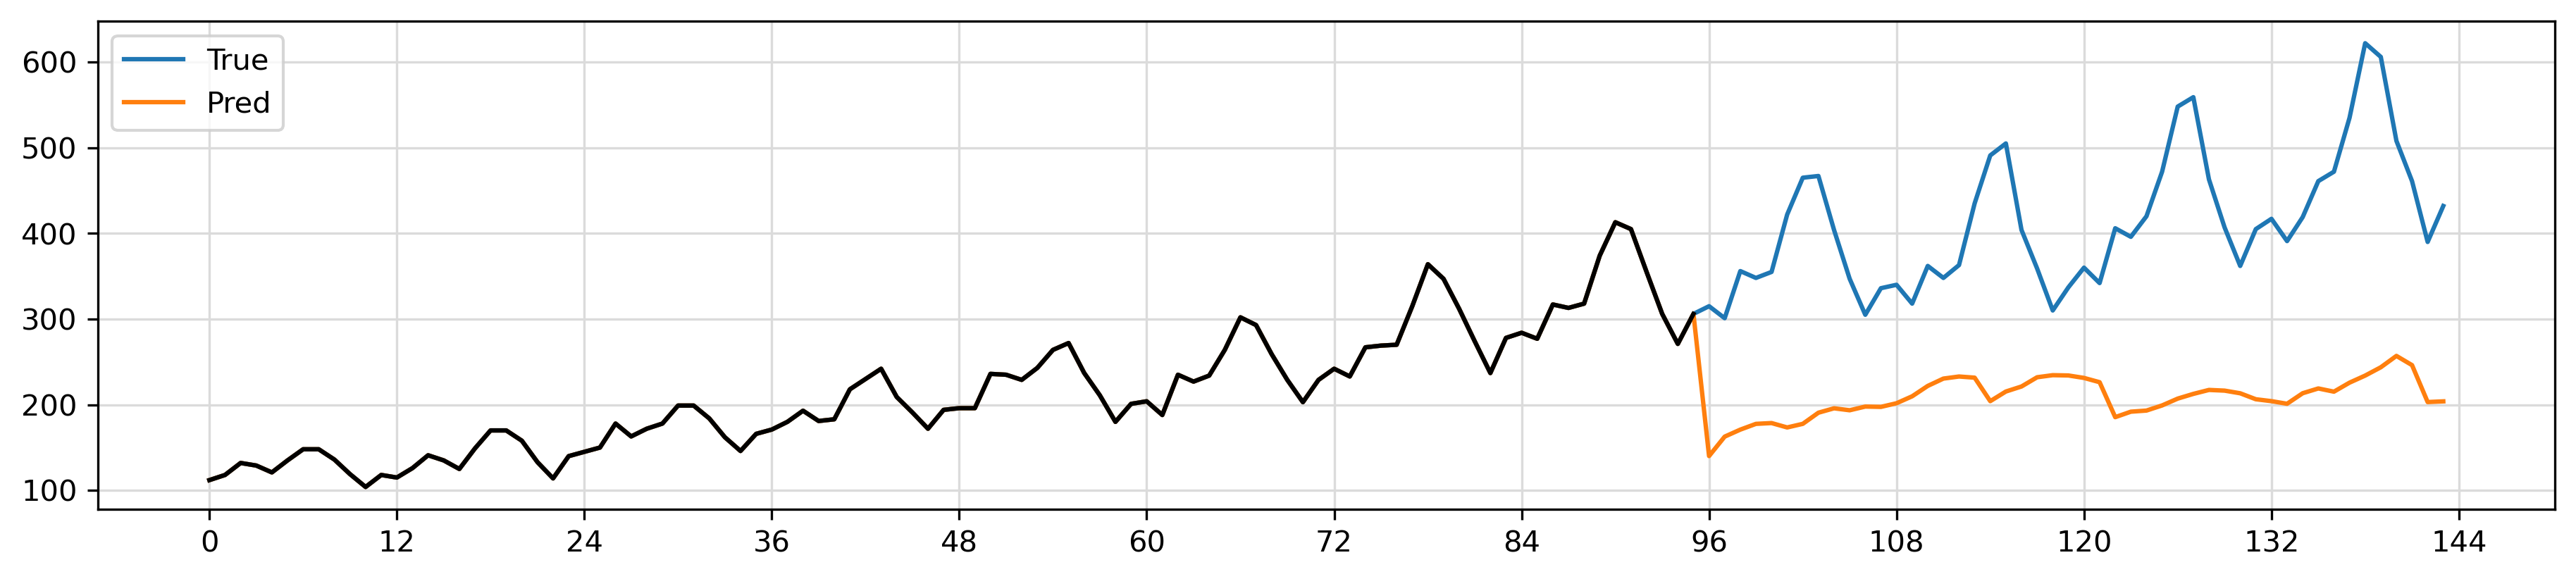

In [6]:
serializer = Serializer(time_sep=' ,', bit_sep=' ', minus_sign=' -',)
serialized_train_data = serializer.serialize(transformed_train_data)
print(serialized_train_data)

pred_list = []
i = 0
while i < num_samples:    
    try:
        question = [
            {"role": "system", "content": sys_message},
            {"role": "user", "content": extra_input + serialized_train_data}
        ]

        preds = []
        while len(preds) < pred_len:
            serialized_answer = create_chat_completion("chatglm3-6b", question)
            transformed_answer = serializer.deserialize(serialized_answer)[:-1]
            answer = scaler.inv_transform(transformed_answer)
            preds.extend(answer)

            question.append({"role": "assistant", "content": serializer.serialize(transformed_answer)})
            question.append({"role": "user", "content": continue_input})

        pred_list.append(preds[:pred_len])
        i += 1
        print(i)
    except:
        pass

pred_list = np.array(pred_list)
print(pred_list.shape)
pred_data = np.mean(pred_list, axis=0)
visualize(train_data, test_data, pred_data)